In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimBifur, SymsimTree, SymsimBranch, SymsimLinear, dyngenCircle, SymsimCycle
from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.autoencoder import AutoEncoder
from math import sqrt
import scprep
import utils
import backbone

from torch_geometric.data import Data

In [2]:
# dataBifur = SymsimBifur()
dataTree = SymsimTree()
# dataBranch = SymsimBranch()
# datalinear = SymsimLinear()
# dataCircle = SymsimCycle()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataTree.num_features

300

In [3]:
data = dataTree[3]
results = backbone.backbone_finding(data)
groups = results['seg_groups']
cell_bb = results['cell_groups']
T = results['mst']
adj_groups = results['origin_conn']
seg = results['seg']

True
running Leiden clustering
finished
number of clusters:  16


In [4]:
import umap
Umap = umap.UMAP(n_components = 2, n_neighbors=30)
X_umap = Umap.fit_transform(np.array(seg['seg_features']))


(16, 16)
(16, 16)


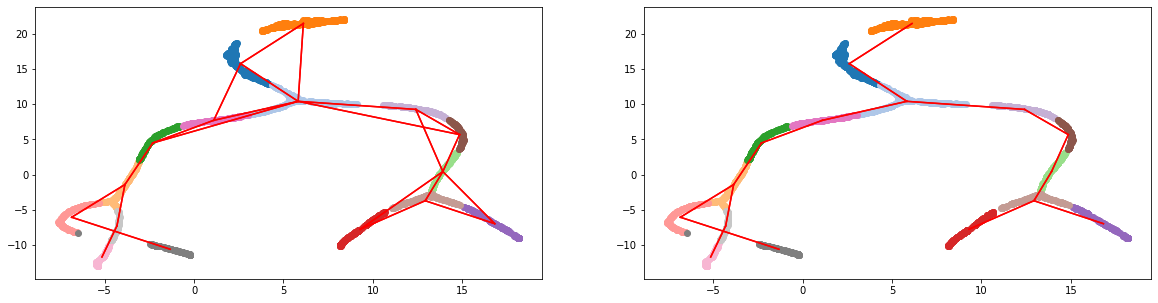

In [5]:
fig = plt.figure(figsize = (20,5))
ax1, ax2 = fig.subplots(1,2)
mean_cluster = [[] for x in range(adj_groups.shape[0])]

cmap = plt.get_cmap('tab20')
for i, cat in enumerate(np.unique(groups)):
    idx = np.where(groups == cat)[0]
    cluster = ax1.scatter(X_umap[idx,0], X_umap[idx,1], color = cmap(i), cmap = 'tab20')
    cluster.set_label("group"+str(cat))

    cluster = ax2.scatter(X_umap[idx,0], X_umap[idx,1], color = cmap(i), cmap = 'tab20')
    cluster.set_label("group"+str(cat))
    mean_cluster[int(cat)] = [np.mean(X_umap[idx,0]), np.mean(X_umap[idx,1])]    

# ax2.legend()

# print(adj_groups.shape)
T_ori = adj_groups > 0.01


print(T_ori.shape)
for i in range(adj_groups.shape[0]):
    for j in range(adj_groups.shape[1]):
        if T_ori[i,j] != 0 and mean_cluster[i] != [] and mean_cluster[j] != []:
            ax1.plot([mean_cluster[i][0], mean_cluster[j][0]], [mean_cluster[i][1], mean_cluster[j][1]], 'r-')

# print(adj_groups.shape)
T_ori = T

mst = np.zeros(T_ori.shape)

print(T_ori.shape)
for i in range(adj_groups.shape[0]):
    for j in range(adj_groups.shape[1]):
        if T_ori[i,j] != 0 and mean_cluster[i] != [] and mean_cluster[j] != []:
            ax2.plot([mean_cluster[i][0], mean_cluster[j][0]], [mean_cluster[i][1], mean_cluster[j][1]], 'r-')


(16, 16)


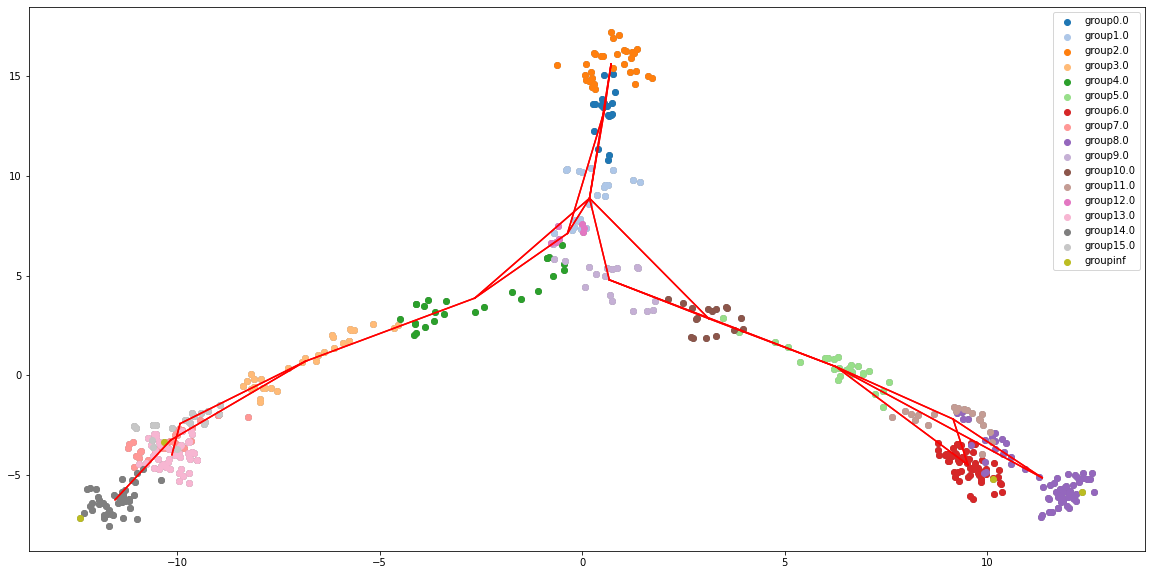

In [8]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

X = data.x.numpy()
X_pca = utils.pca_op(X, n_comps=30, standardize=False)

ax.scatter(X_pca[:,0], X_pca[:,1], color = 'gray')
cmap = plt.get_cmap('tab20')
mean_cluster = [[] for x in range(adj_groups.shape[0])]
for i, cat in enumerate(np.unique(cell_bb)):
    idx = np.where(cell_bb == cat)[0]
    cluster = ax.scatter(X_pca[idx,0], X_pca[idx,1], color = cmap(i), cmap = 'tab20')
    if cat != np.inf:
        mean_cluster[int(cat)] = [np.mean(X_pca[idx,0]), np.mean(X_pca[idx,1])]    
    cluster.set_label("group"+str(cat))

# print(len(mean_cluster))
ax.legend()
# print(adj_groups.shape)
T_ori = adj_groups > 0.01

mst = np.zeros(T_ori.shape)

print(T_ori.shape)
for i in range(adj_groups.shape[0]):
    for j in range(adj_groups.shape[1]):
        if T_ori[i,j] != 0 and mean_cluster[i] != [] and mean_cluster[j] != []:
            ax.plot([mean_cluster[i][0], mean_cluster[j][0]], [mean_cluster[i][1], mean_cluster[j][1]], 'r-')
            mst[i,j] = np.linalg.norm(np.array(mean_cluster[i]) - np.array(mean_cluster[j]), ord = 2)

(16, 16)


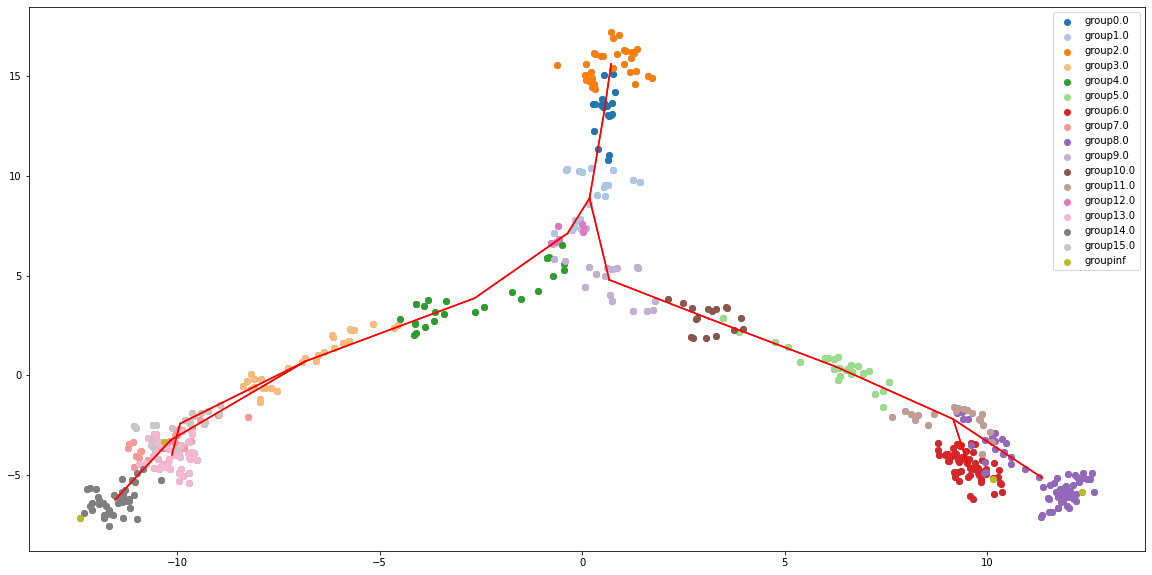

In [9]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(X_pca[:,0], X_pca[:,1], color = 'gray')
cmap = plt.get_cmap('tab20')
mean_cluster = [[] for x in range(adj_groups.shape[0])]
for i, cat in enumerate(np.unique(cell_bb)):
    idx = np.where(cell_bb == cat)[0]
    cluster = ax.scatter(X_pca[idx,0], X_pca[idx,1], color = cmap(i), cmap = 'tab20')
    if cat != np.inf:
        mean_cluster[int(cat)] = [np.mean(X_pca[idx,0]), np.mean(X_pca[idx,1])]    
    cluster.set_label("group"+str(cat))

# print(len(mean_cluster))
ax.legend()
# print(adj_groups.shape)
T_ori = adj_groups > 0.01
T_ori = T

print(T_ori.shape)
for i in range(adj_groups.shape[0]):
    for j in range(adj_groups.shape[1]):
        if T_ori[i,j] != 0 and mean_cluster[i] != [] and mean_cluster[j] != []:
            ax.plot([mean_cluster[i][0], mean_cluster[j][0]], [mean_cluster[i][1], mean_cluster[j][1]], 'r-')
